# Bayesian Symbolic Regression (BSR)

## Introduction

Symbolic regression (SR) refers to a class of algorithms that search for interpretable symbolic expressions which capture relationships within data. More specifically, SR attempts to find compositions of simple functions that accurately map independent variables to dependent variables within a given dataset. Bayesian Symbolic Regression, proposed by [Jin et. al (2019)](https://arxiv.org/abs/1910.08892), is a specific SR method that uses a Bayesian framework to search for concise and interpretable expressions. The following are its main contributions, listed in sequential order:

1. It models equations as expression trees, with root and intermediate tree nodes representing operators (e.g. `*` for a binary node and `sin` for a unary node) and leaf nodes representing features in the data. BSR then defines the search space as the union of the following three parts:
    - Tree structure (T): this represents the structure of the expression tree (e.g. how to recursively construct the tree and when to stop by using leaf nodes), and also specifies the assignment of operators to non-leaf nodes.
    - Leaf nodes (M): this assigns features to leaf nodes that are already defined from part **T**.
    - Operator parameters ($\Theta$): this uses a vector $\Theta$ to collect additional parameters for certain operators which require them (e.g. a linear operator `ln` with intercept and slope params).

2. It specifies priors for each of the three parts above. `Autora`'s implementation of BSR allows users to either specify custom priors for part `T` or choose among a pre-specified set.

3. It defines `actions` that mutate one expression tree (`original`) into a new expression tree (`proposed`), and supports the calculation of transition probabilities based on the likelihoods of the `original` and `proposed` models.

4. It designs and implements a Reversible-Jump Markov-Chain Monte-Carlo algorithm (RJ-MCMC), which iteratively accepts new samples (where each sample is a valid expression tree) based on the transition probabilities calculated above. In each iteration, `K` expression trees are obtained either from the `original` samples or the new `proposed` samples.

5. With each iteration, the candidate prediction model is a linear mixture of the `K` trees, wherein the ground truth response is regressed on the results generated by the `K` expression trees to obtain the linear regression parameters $\beta$.

`AutoRA`'s implementation of BSR is adapted from original authors' [codebase](https://github.com/ying531/MCMC-SymReg), and includes comprehensive refactoring of data structures and MCMC computations. It also provides new priors that suit the cognitive and behavioral sciences.

## Meta-Parameters

Meta-Parameters are used to control the search space and the model configuration. In BSR, they are mainly defined in the theorist constructor (see `bsr.py`). Below is a basic overview of these parameters. Note, there are additional algorithm-irrelevant configurations that can be customized in the constructor; please refer to code documentation for their details.

- `tree_num`: the number of expression trees to use in the linear mixture (final prediction model); also denoted by `K` in BSR.
- `iter_num`: the number of RJ-MCMC steps to execute (note: this can also be understood as the number of `K`-samples to take in the fitting process).
- `val`: the number of validation steps to execute following each iteration.
- `beta`: the hyperparameter that controls growth of a new expression tree. This needs to be < 0, and in general, smaller values of `beta` correspond to deeper expression trees.

## Search Space

The following are built-in operators which constitute the search space:

- **\+**: The output of the computation $x_j$ is the sum over its inputs $x_i, x_{ii}$: $x_j = x_i + x_{ii}$.
- **\-**: The output of the computation $x_j$ is the respective difference between its inputs $x_i, x_{ii}$: $x_j = x_i - x_{ii}$.
- __\*__: The output of the computation $x_j$ is the product over its two inputs $x_i, x_{ii}$: $x_j = x_i * x_{ii}$.
- **exp**: The output of the computation $x_j$ is the natural exponential function applied to its input $x_i$: $x_j = \exp(x_i)$.
- **pow2**: The output of the computation $x_j$ is the square function applied to its input $x_i$: $x_j$ = $x_i^2$.
- **pow3**: The output of the computation $x_j$ is the cube function applied to its input $x_i$: $x_j$ = $x_i^3$.
- **sin**: The output of the computation $x_j$ is the sine function applied to its input $x_i$: $x_j = \sin(x_i)$.
- **cos**: The output of the computation $x_j$ is the cosine function applied to its input $x_i$: $x_j = \cos(x_i)$.
- **ln**: The output of the computation $x_j$ is the linear transformation applied to its input $x_i$: $x_j = a * x_i + b$, where $a$ and $b$ are slope and intercept parameters.

In BSR, a new operator can be added in two steps. First, define an operator as a function, as demonstrated in `operations.py`. Second, add the name of the operator and its prior information to the dictionaries in `__get_prior()` within `prior.py`.

## Examples

The following toy example shows out-of-the-box functionality of BSR. It first generates data using the equation, $y = \sin(x) + x^3$, as ground-truth, and then fits the data with default meta-parameters. For ease and efficiency of illustration, it applies a small number of iterations, `itr_num`. As displayed in the plot below, the algorithm provides results that are not only reasonable, but exactly match the ground-truth equation.

In [ ]:
# Uncomment the following line when running on Google Colab
# !pip install autora

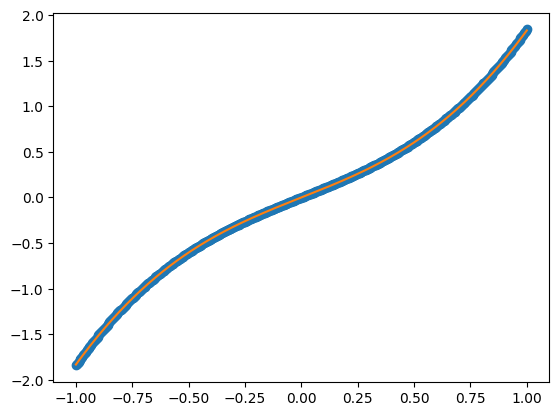

In [28]:
from autora.skl.bsr import BSRRegressor
import numpy as np
import matplotlib.pyplot as plt

x = np.expand_dims(np.linspace(start=-1, stop=1, num=500), 1)
y = np.power(x, 3) + np.sin(x)

# initialize regressor
bsr = BSRRegressor(itr_num = 500)
bsr.fit(x, y)
y_pred = bsr.predict(x)

# plot out the ground truth versus predicted responses
plt.figure()
plt.plot(x, y, "o")
plt.plot(x, y_pred, "-")
plt.show()

<br>

## References
Jin, Ying, et al. "Bayesian symbolic regression." arXiv preprint arXiv:1910.08892 (2019).
